<a href="https://colab.research.google.com/github/Priyo-prog/Time-series-analysis/blob/main/Forecasting/the_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Forecasting**

Forecasting based on simple AR(1) model

Compare the results with the actual values for each period.

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 903 kB 5.5 MB/s 
     |████████████████████████████████| 9.8 MB 52.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
!pip3 install numpy scipy patsy pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip3 install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Delete the "!pip uninstall statsmodels" once the installation is complete

## Import Libraries and Packages

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA # new special package for ARIMA models
from scipy.stats.distributions import chi2
import yfinance
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set()

## Import the Data

In [6]:
raw_data = yfinance.download(tickers="^GSPC ^FTSE ^N225 ^GDAXI", start="1994-01-07", end="2018-01-29",
                             interval="1d", group_by="ticker", auto_adjust=True, treads=True)

[*********************100%***********************]  4 of 4 completed


## Preprocess the Data

In [7]:
df_comp = raw_data.copy()

In [8]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

In [9]:
df_comp = df_comp.iloc[1:]
del df_comp['^GSPC'], df_comp['^GDAXI'], df_comp['^FTSE'], df_comp['^N225']

In [10]:
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')
df_comp.head()

,spx,dax,ftse,nikkei
,,,,
Date,,,,
1994-01-10,475.269989,2225.000000,3440.600098,18443.439453
1994-01-11,474.130005,2228.100098,3413.800049,18485.250000
1994-01-12,474.170013,2182.060059,3372.000000,18793.880859
1994-01-13,472.470001,2142.370117,3360.000000,18577.259766
1994-01-14,474.910004,2151.050049,3400.600098,18973.699219


## Creating Returns

In [11]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1)*100
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1)*100
df_comp['ret_dax'] = df_comp.dax.pct_change(1)*100
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1)*100

## Splitting theTraining and Testing Sets

In [12]:
## Getting the 80% of data as training set
size = int(len(df_comp) * 0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## The Log-Likelihood Test

In [13]:
def llr_test(mod_1, mod_2, DF=1):
   """ mod_1, mod_2= models to compare, df=degrees of freedom"""
   L1 = mod_1.fit(trend='nc').llf ## Add trend='ct'
   L2 = mod_2.fit(trend='nc').llf ## log likelihood
   LR = (2*(L2-L1)) ## test statistics
   p = chi2.sf(LR, DF).round(3) ## p-value
   return p

## Fitting a Model AR(1)

In [14]:
from statsmodels.tsa.arima.model import ARIMA

In [15]:
model_ar = ARIMA(df.ftse, order=(1,0,0))
results_ar = model_ar.fit()
print(results_ar.summary())

                               SARIMAX Results                                
Dep. Variable:                   ftse   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -27617.795
Date:                Fri, 05 Aug 2022   AIC                          55241.590
Time:                        01:48:38   BIC                          55261.153
Sample:                    01-10-1994   HQIC                         55248.445
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.9587    423.016     12.033      0.000    4260.863    5919.054
ar.L1          0.9984      0.001   1148.918      0.000       0.997       1.000
sigma2      3512.3482     40.899     85.879      0.0

## Simple Forecasting

We must choose time interval for forecasting. Choose a **start-date** and **end-date** for forecasting of time-series.

The first day after the end of the Training Set.



In [16]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei
,,,,,,,,
Date,,,,,,,,
2013-04-01,1562.170044,7795.310059,6411.700195,12135.019531,-0.447358,0.000000,0.000000,-2.120443
2013-04-02,1570.250000,7943.870117,6490.700195,12003.429688,0.517226,1.232122,1.905762,-1.084381
2013-04-03,1553.689941,7874.750000,6420.299805,12362.200195,-1.054613,-1.084635,-0.870106,2.988900
2013-04-04,1559.979980,7817.390137,6344.100098,12634.540039,0.404845,-1.186856,-0.728402,2.203005
2013-04-05,1553.280029,7658.750000,6249.799805,12833.639648,-0.429490,-1.486425,-2.029324,1.575836


In [18]:
start_date = '2013-04-06'
end_date = '2014-01-01'

In [29]:
end_date = '2018-01-01'
end_date

'2018-01-01'

In [30]:
df_pred = results_ar.predict(start=start_date, end=end_date)

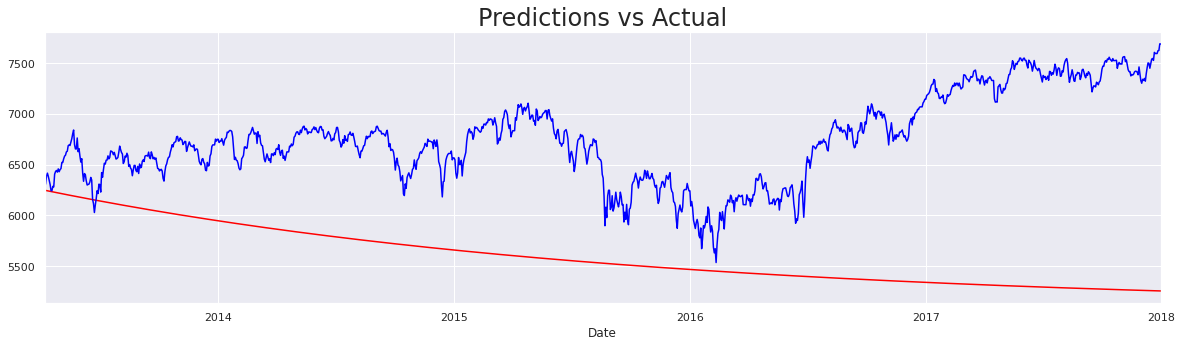

In [32]:
df_pred[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ftse[start_date:end_date].plot(color='blue')
plt.title("Predictions vs Actual", size=24)
plt.show()

We see a constantly decreasing line which is not absolutely realistic.

AR model is bad in estimating the non-stationary data.

## Using Returns Instead

In [34]:
end_date = '2018-01-01'

model_ret_ar = ARIMA(df.ret_ftse[1:], order=(1,0,0))
results_ret_ar = model_ret_ar.fit()

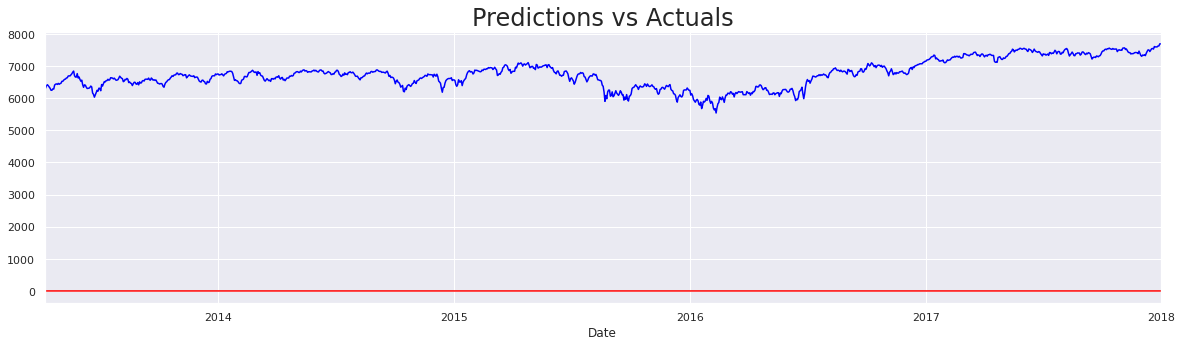

In [36]:
df_ret_pred_ar = results_ret_ar.predict(start=start_date, end=end_date)

df_ret_pred_ar[start_date:end_date].plot(figsize=(20,5), color="red")
df_test.ftse[start_date:end_date].plot(color="blue")
plt.title("Predictions vs Actuals", size=24)
plt.show()

The prediction line is constant at 0, it makes no prediction since it assumes that all future returns will be 0, or extremely close to it.